# Pre-block Assignment 1

## Library & Data Import

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import display as dsp 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import plotly.express as px
from collections import Counter
from sklearn.preprocessing import LabelEncoder as le
import category_encoders as ce
fig_dir = 'Figures/'
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

## Data Understanding

In [2]:
dsp(df.head())


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
df.drop('id', axis=1)
binary_map = {
    0:'No',
    1:'Yes'
}
df.hypertension = df.hypertension.map(binary_map)
df.heart_disease = df.heart_disease.map(binary_map)
df.stroke = df.stroke.map(binary_map)

### Feature Description

In [4]:
feats = df.columns.values
numeric_feats = df._get_numeric_data().columns.values
cat_feats = list(set(feats) - set(numeric_feats))

print("Features:\n",feats,'\n\n')
print("Numerical Features:\n",numeric_feats,'\n\n')
print("Categorical Features:\n",cat_feats,'\n\n')
print('Feature Datatypes')
print(df.dtypes)

Features:
 ['id' 'gender' 'age' 'hypertension' 'heart_disease' 'ever_married'
 'work_type' 'Residence_type' 'avg_glucose_level' 'bmi' 'smoking_status'
 'stroke'] 


Numerical Features:
 ['id' 'age' 'avg_glucose_level' 'bmi'] 


Categorical Features:
 ['smoking_status', 'Residence_type', 'stroke', 'gender', 'heart_disease', 'work_type', 'hypertension', 'ever_married'] 


Feature Datatypes
id                     int64
gender                object
age                  float64
hypertension          object
heart_disease         object
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                object
dtype: object


In [5]:
for feat in cat_feats:
    print(feat , ':',df[feat].unique())

smoking_status : ['formerly smoked' 'never smoked' 'smokes' 'Unknown']
Residence_type : ['Urban' 'Rural']
stroke : ['Yes' 'No']
gender : ['Male' 'Female' 'Other']
heart_disease : ['Yes' 'No']
work_type : ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
hypertension : ['No' 'Yes']
ever_married : ['Yes' 'No']


### Missing Values

In [6]:
df_smoking = df.copy()
df_smoking.smoking_status = df.smoking_status.replace({'Unknown':None})

In [7]:
print("Missing values per feature\n")
null_features = df_smoking.isnull().sum() 
print(null_features,'\n')
percent_missing_bmi = round((null_features['bmi']/df_smoking.shape[0]*100),2)
percent_missing_smoking = round((null_features['smoking_status']/df_smoking.shape[0]*100),2)

print(f'% values missing for bmi: {percent_missing_bmi}% ')
print(f'% values missing for smoking_status: {percent_missing_smoking}% ')
rows_with_missing = df_smoking.shape[0] - df_smoking.dropna().shape[0]
percent_rows_missing = round(rows_with_missing/df.shape[0],4)*100
print('Number of rows with at least one missing value: ', rows_with_missing)
print('Percentage of rows with at least one missing value:', percent_rows_missing,'%')

Missing values per feature

id                      0
gender                  0
age                     0
hypertension            0
heart_disease           0
ever_married            0
work_type               0
Residence_type          0
avg_glucose_level       0
bmi                   201
smoking_status       1544
stroke                  0
dtype: int64 

% values missing for bmi: 3.93% 
% values missing for smoking_status: 30.22% 
Number of rows with at least one missing value:  1684
Percentage of rows with at least one missing value: 32.95 %


In [8]:
bmi_na = df.loc[df.bmi.isna()]
print('Stroke Values for missing BMI observations')
bmi_na.stroke.value_counts()

Stroke Values for missing BMI observations


No     161
Yes     40
Name: stroke, dtype: int64

In [9]:
#Fill bmi with mean
print('Median:',df.bmi.median())
df.bmi = df.bmi.fillna(df.bmi.median())
df_smoking.bmi = df_smoking.bmi.fillna(df_smoking.bmi.median())

Median: 28.1


In [10]:
print('Stroke Values for missing smoking_status observations')
smoke_na = df_smoking.loc[df_smoking.smoking_status.isna()]
smoke_na.stroke.value_counts()

Stroke Values for missing smoking_status observations


No     1497
Yes      47
Name: stroke, dtype: int64

In [11]:
df_smoking.smoking_status=df_smoking.smoking_status.fillna(df.smoking_status.mode()[0])

#### Feature Importance for Unknown smoking_status set to None and imputed with mode

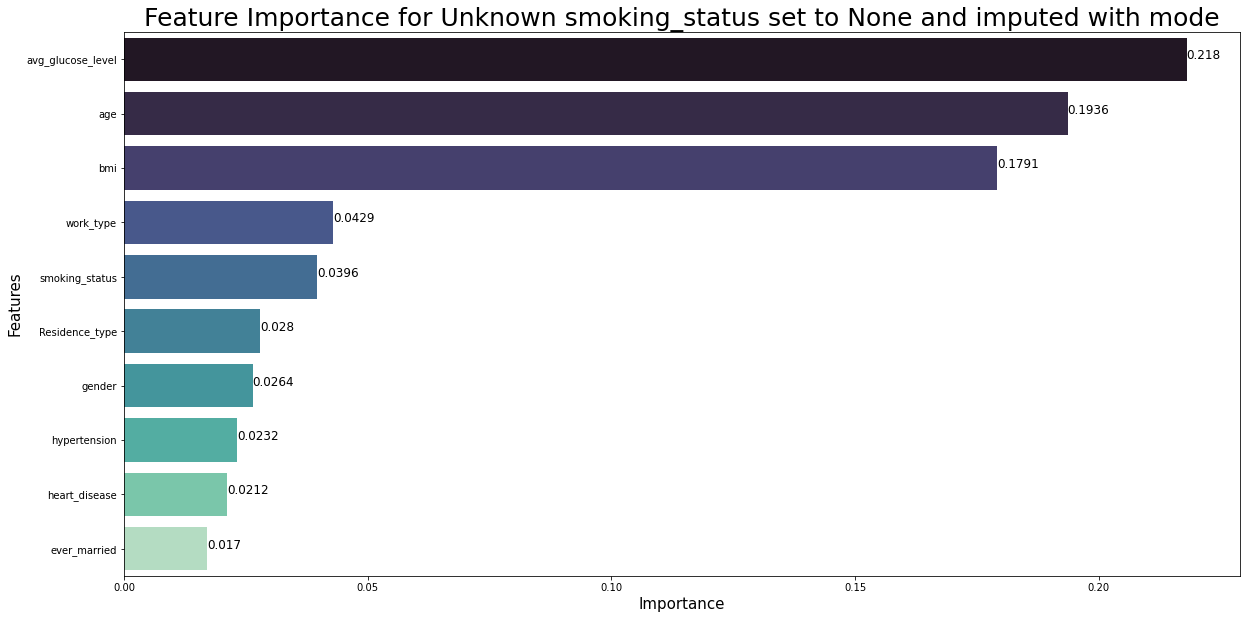

In [12]:
encoder = le()
df_enc = df_smoking.copy()
for feat in cat_feats:
    df_enc[feat] = encoder.fit_transform(df_smoking[feat].values)
X= df_enc[df_enc.columns.difference(['stroke'])]
y= df_enc.stroke
    
    
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X,y)
importances = list(rf.feature_importances_)
columns = list(X.columns.values)
id_index =list(columns).index('id')
columns.remove('id')
importances.remove(importances[id_index])
n = len(importances)
for i in range(len(importances)-1):
    for j in range(0,n-i-1):
        if importances[j]<importances[j+1]:
            importances[j], importances[j+1] = importances[j+1], importances[j]
            columns[j], columns[j+1] = columns[j+1], columns[j]
            
plt.figure(figsize = (20,10))
fig = sns.barplot(y=columns,
            x=importances,
            palette='mako'
)

for index, value in enumerate(np.round(np.array(importances),4)):
    plt.text(value, index, str(value), fontsize=12)
plt.title('Feature Importance for Unknown smoking_status set to None and imputed with mode', fontsize=25)
plt.xlabel('Importance' , fontsize=15)
plt.ylabel('Features', fontsize=15)
plt.savefig(fig_dir+'feat_impo_smoking_none.png')
plt.show()

#### Feature Importance for smoking_status left with Unknown

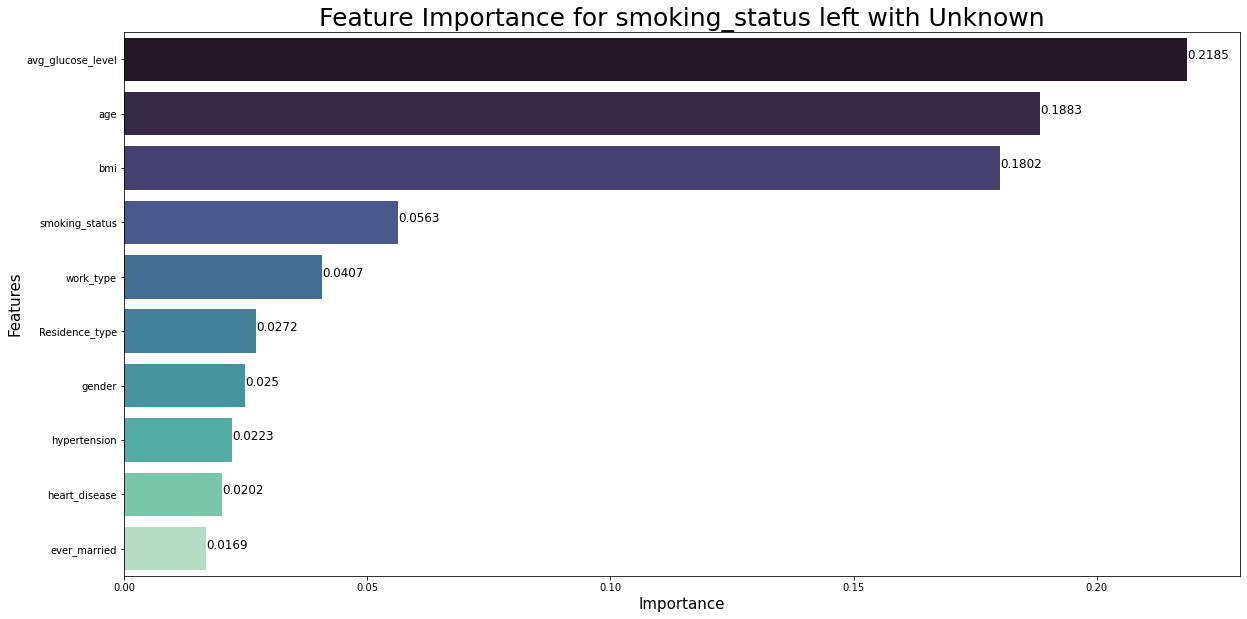

In [13]:
encoder = le()
df_enc = df.copy()
for feat in cat_feats:
    df_enc[feat] = encoder.fit_transform(df[feat].values)
X= df_enc[df_enc.columns.difference(['stroke'])]
y= df_enc.stroke
    
    
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X,y)
importances = list(rf.feature_importances_)
columns = list(X.columns.values)
id_index =list(columns).index('id')
columns.remove('id')
importances.remove(importances[id_index])
n = len(importances)
for i in range(len(importances)-1):
    for j in range(0,n-i-1):
        if importances[j]<importances[j+1]:
            importances[j], importances[j+1] = importances[j+1], importances[j]
            columns[j], columns[j+1] = columns[j+1], columns[j]
            
plt.figure(figsize = (20,10))
fig = sns.barplot(y=columns,
            x=importances,
            palette='mako'
)

for index, value in enumerate(np.round(np.array(importances),4)):
    plt.text(value, index, str(value), fontsize=12)
plt.title('Feature Importance for smoking_status left with Unknown', fontsize=25)
plt.xlabel('Importance' , fontsize=15)
plt.ylabel('Features', fontsize=15)
plt.savefig(fig_dir+'feat_impo_smoking_stat_normal.png')
plt.show()

### Data Quality Report 

In [14]:
print('Data Quality Report for Numerical Features')
dsp(df.describe())
print('Data Quality Report for Categorical Features')
dsp(df.describe(include='object'))

Data Quality Report for Numerical Features


,id,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,5110.000000,5110.000000
mean,36517.829354,43.226614,106.147677,28.862035
std,21161.721625,22.612647,45.283560,7.699562
min,67.000000,0.080000,55.120000,10.300000
25%,17741.250000,25.000000,77.245000,23.800000
50%,36932.000000,45.000000,91.885000,28.100000
75%,54682.000000,61.000000,114.090000,32.800000
max,72940.000000,82.000000,271.740000,97.600000


Data Quality Report for Categorical Features


,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke
count,5110,5110,5110,5110,5110,5110,5110,5110
unique,3,2,2,2,5,2,4,2
top,Female,No,No,Yes,Private,Urban,never smoked,No
freq,2994,4612,4834,3353,2925,2596,1892,4861


### Target Variable Balance

In [15]:
num_positive_target = len(df.loc[df.stroke=='Yes'])
num_negative_target = len(df.loc[df.stroke=='No'])
percentage_positive = round((num_positive_target/df.shape[0])*100,2)
percentage_negative = round((num_negative_target/df.shape[0])*100,2)
print('Number of positive target observations:',num_positive_target)
print('Number of negative target observations:',num_negative_target)
print(f'Percentage positive target variables: {percentage_positive} %')
print(f'Percentage negative target variables: {percentage_negative} %')

fig = px.pie(
    df, 
    names='stroke',
    color_discrete_sequence=px.colors.diverging.balance,
    title='Target Variable Ratio'
)
# fig.write_image(fig_dir+"stroke_ratio.png")
fig.show()

Number of positive target observations: 249
Number of negative target observations: 4861
Percentage positive target variables: 4.87 %
Percentage negative target variables: 95.13 %


### Feature Visualisation

#### Scatter Plot Matrix

C:\Users\abdul\anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(68.09375, 0.5, 'Features_2')

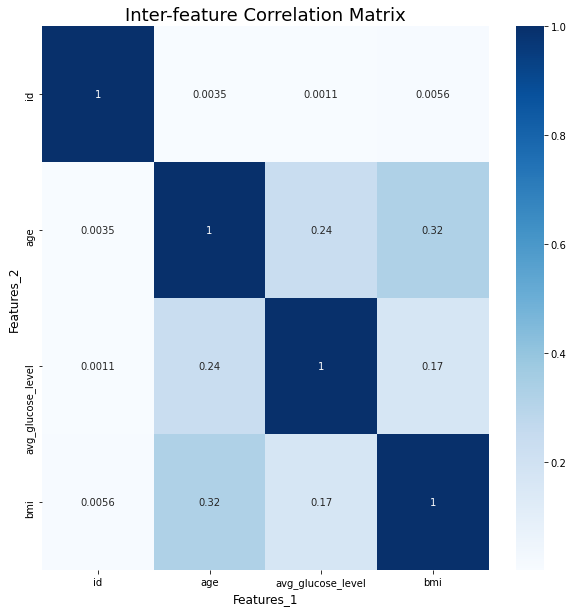

In [16]:

feats = list(numeric_feats)
feats.append('stroke')
df_dropped = df[feats]
df_dropped.stroke = df_dropped.stroke.map({'Yes':1,'No':0})
fig = px.scatter_matrix(
    df , 
    dimensions=['id','age','avg_glucose_level','bmi'],
    color_discrete_sequence=px.colors.diverging.balance,
    color='stroke',
    size_max=10,
    category_orders ={'stroke':['No','Yes']},
    title = 'Scatter Plot Matrix for Numeric Features',
    height = 600,
    width= 800
)

# fig.write_image(fig_dir+"splom.png")
fig.show()



fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(),annot=True,cmap='Blues')
plt.title('Inter-feature Correlation Matrix',fontsize=18)
plt.xlabel('Features_1' , fontsize = 12)
plt.ylabel('Features_2' , fontsize = 12)
# plt.savefig(fig_dir+'feat_corr_0.png')


<Figure size 1440x720 with 0 Axes>

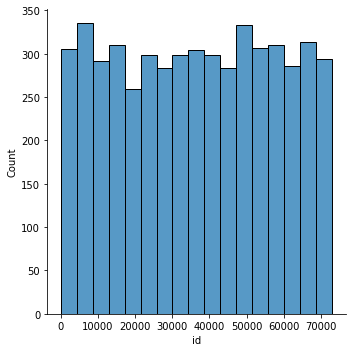

In [17]:
plt.figure(figsize =(20,10))
sns.displot(df ,x='id')


#### Density Plots

##### Numerical Features

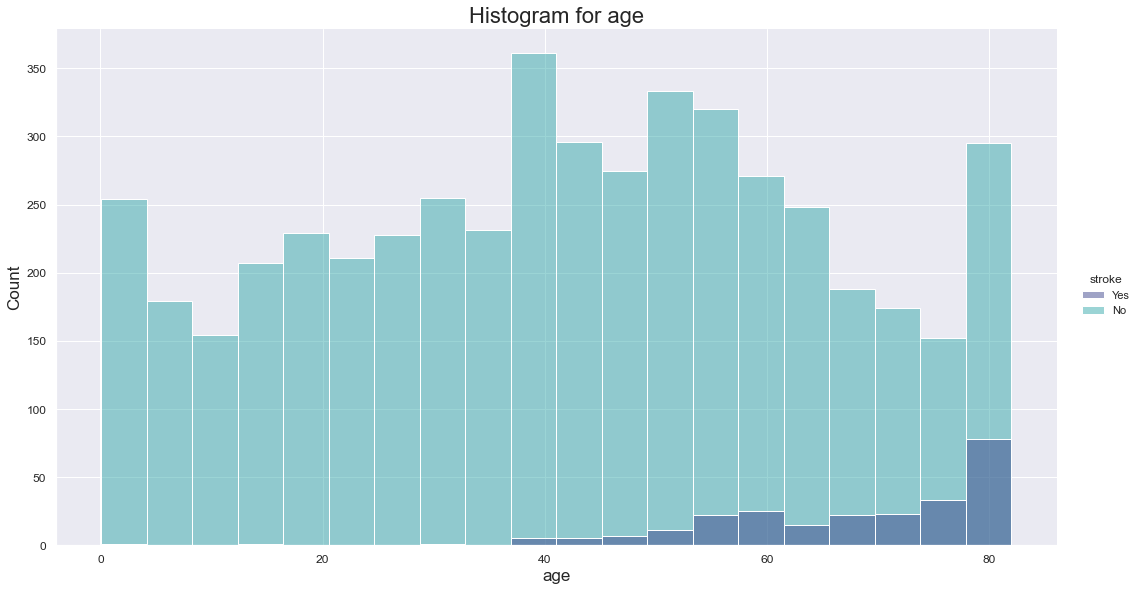

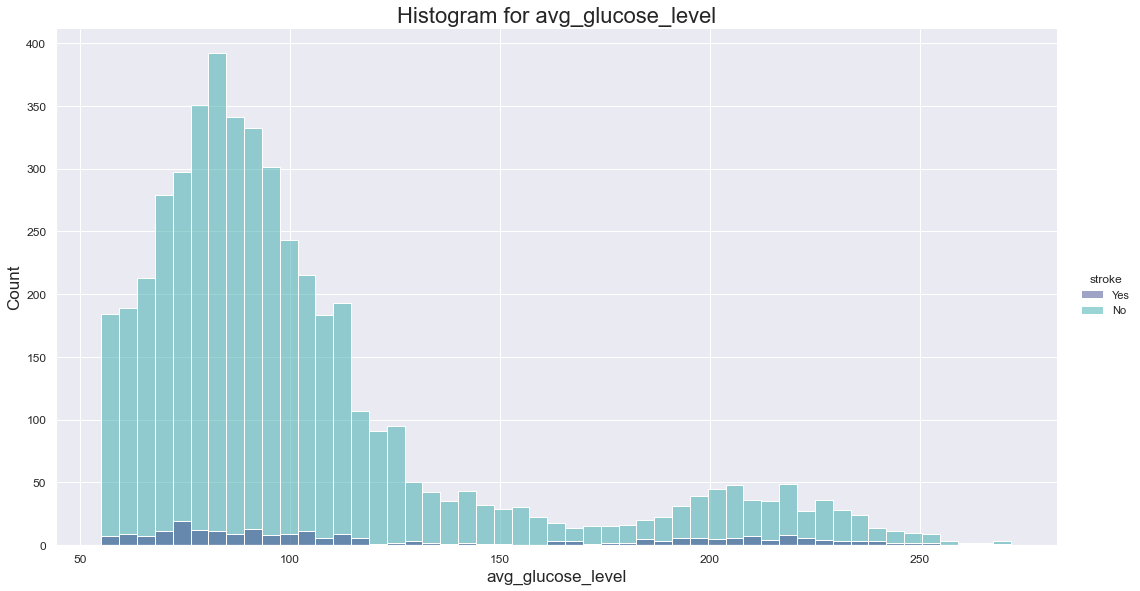

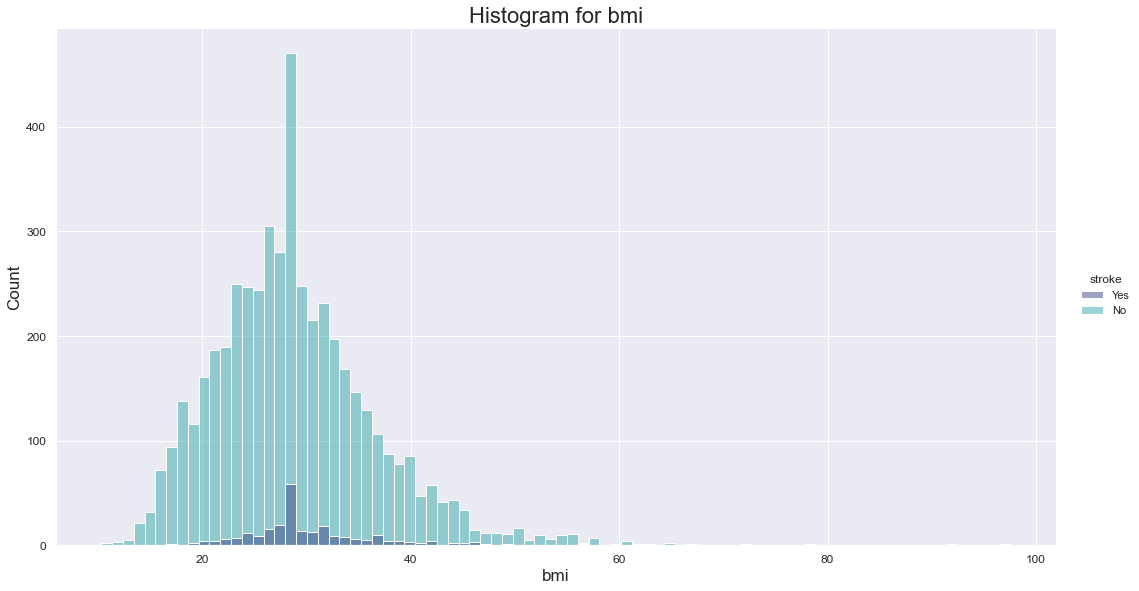

In [18]:
sns.set(rc={'figure.figsize':(20,10)})
sns.set(rc={'figure.figsize':(20,10)})
width = 15
height = 8
feats = list(numeric_feats)
feats.remove('id')
for feature in feats:
    fig=sns.displot(
        df ,x=feature,        
        hue='stroke', 
        palette = 'mako',
        rug_kws=dict(edgecolors=None, linewidth=0),
        height=height, aspect=width/height,
        kind="hist",
        legend=True
    )
    plt.title(f'Histogram for {feature}', fontsize=22)
    plt.xlabel(f'{feature}' , fontsize=17)
    plt.ylabel('Count', fontsize=17)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(fig_dir+f'{feature}_hist.png')
    plt.show()

##### Categorical Features

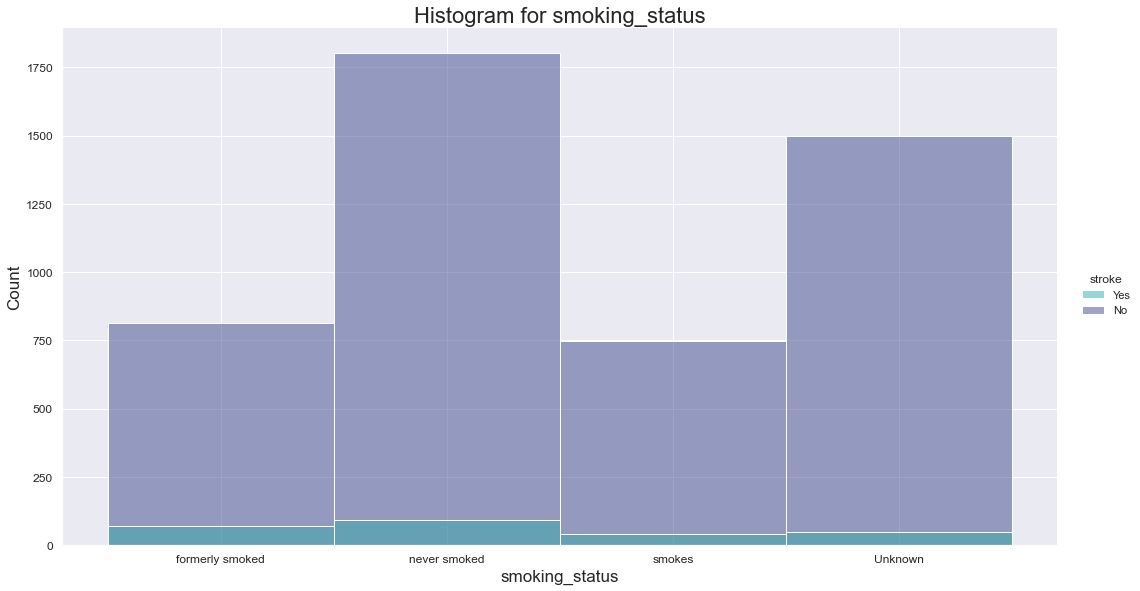

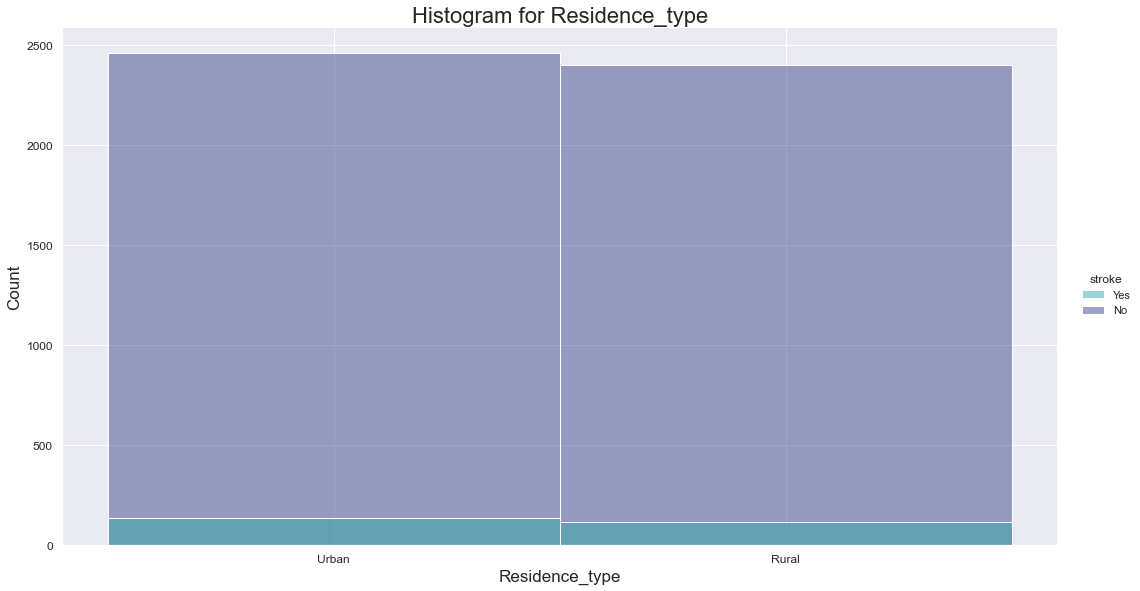

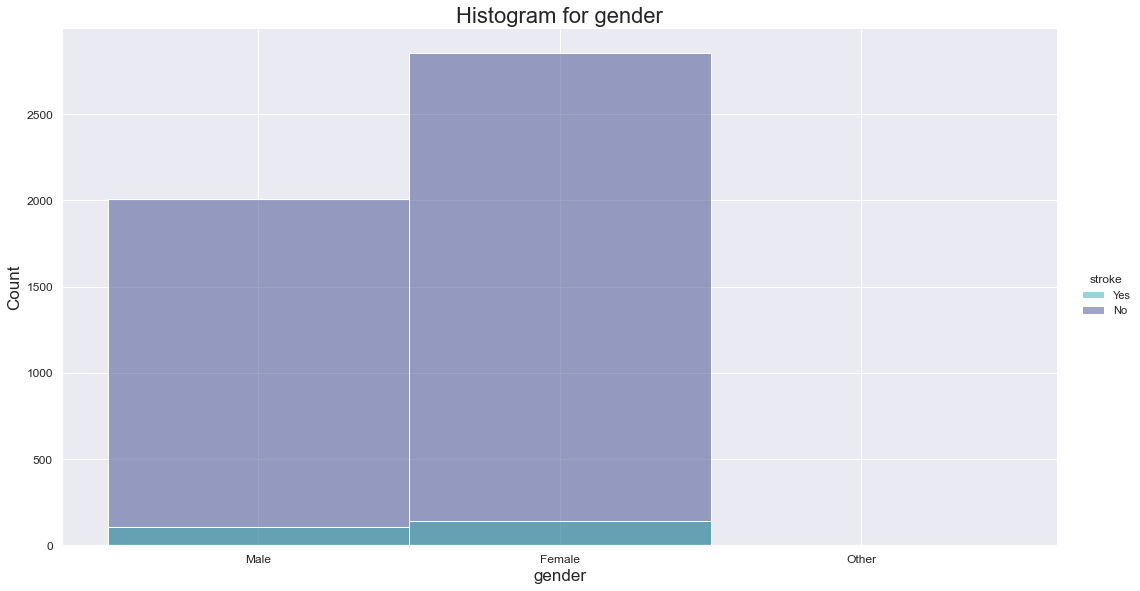

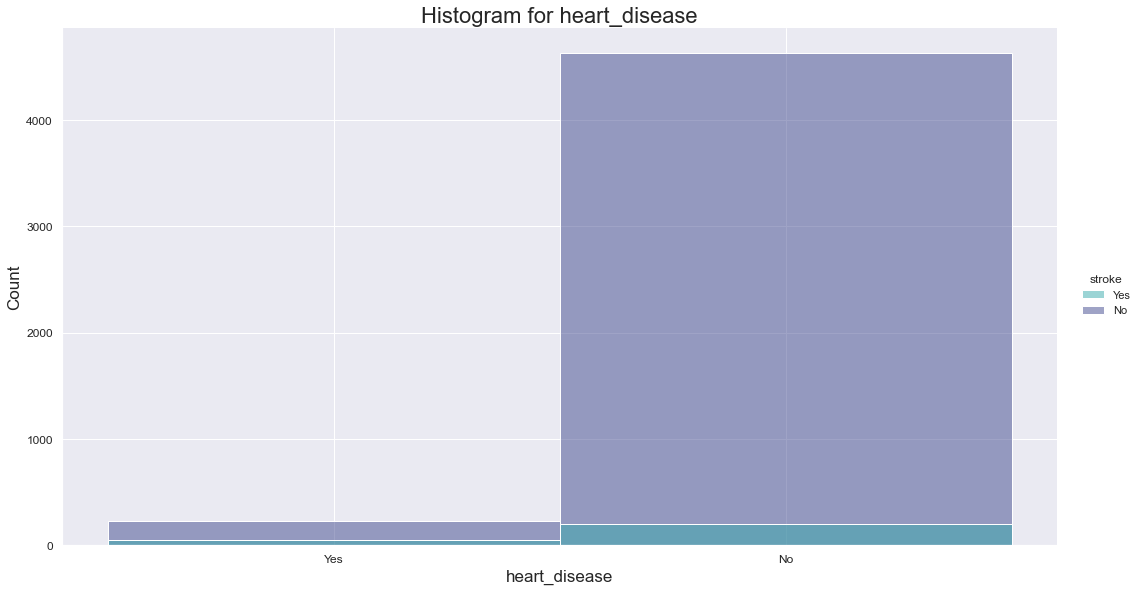

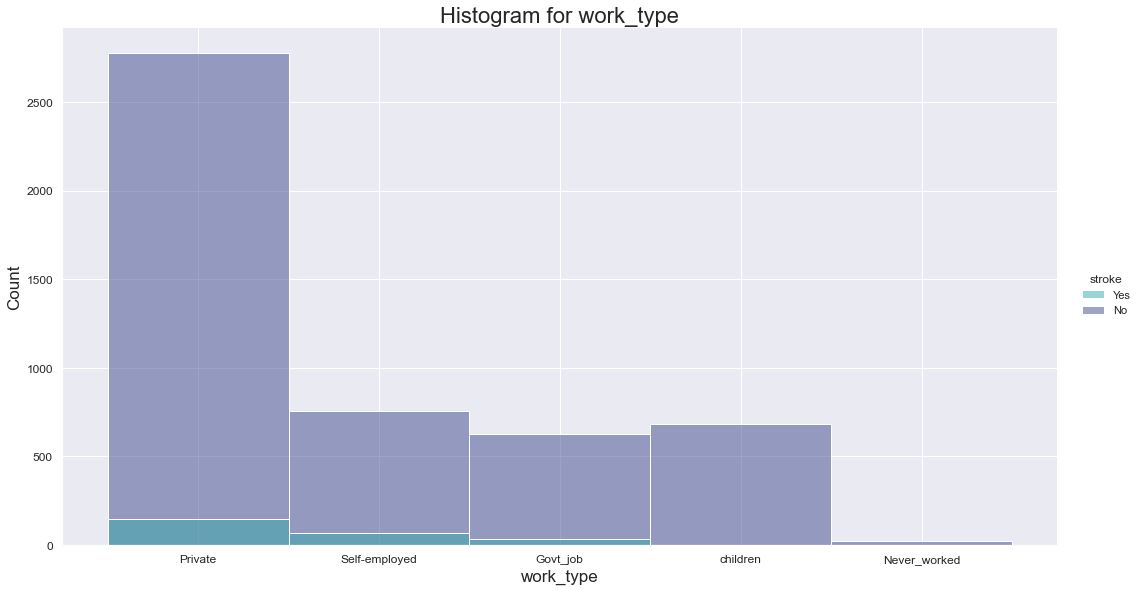

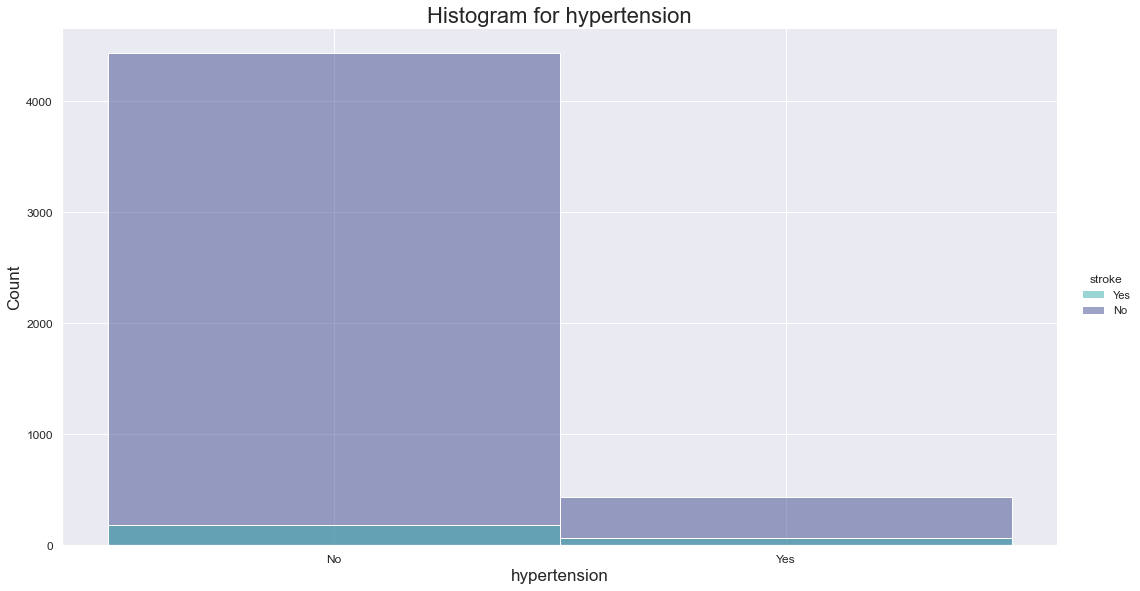

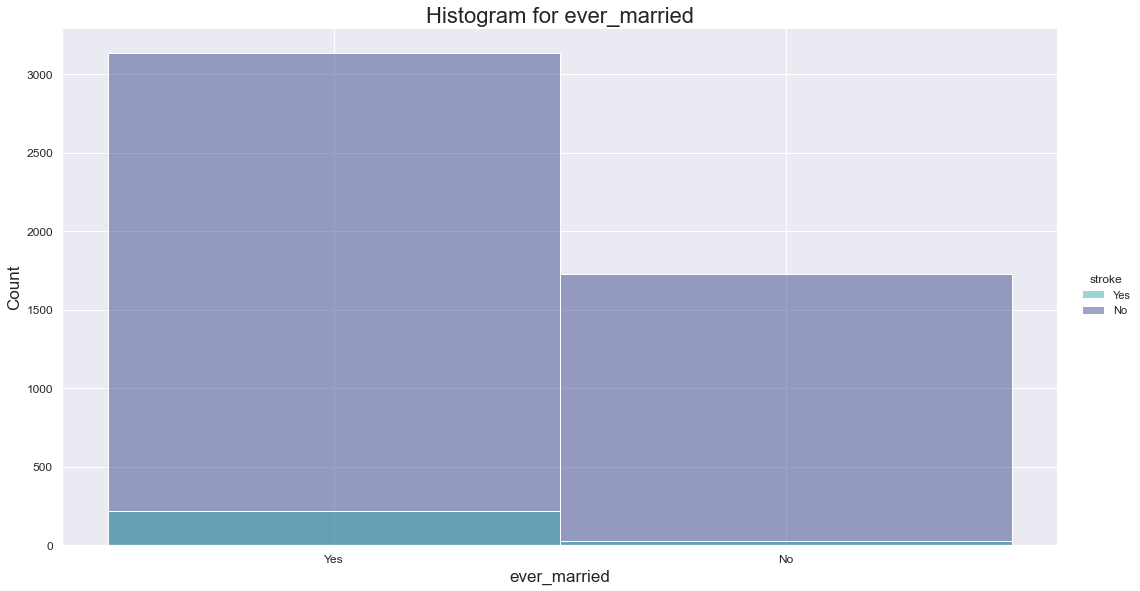

In [19]:
sns.set(rc={'figure.figsize':(20,10)})
width = 15
height = 8
feats = list(cat_feats)
feats.remove('stroke')
for feature in feats:
    sns.displot(
        df ,x=feature, 
        hue='stroke', 
        palette = 'mako_r',
        rug_kws=dict(edgecolors=None, linewidth=0),
        height=height, aspect=width/height,
        kind="hist"
    )
    plt.title(f'Histogram for {feature}', fontsize=22)
    plt.xlabel(f'{feature}' , fontsize=17)
    plt.ylabel('Count', fontsize=17)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(fig_dir+f'{feature}_hist.png')
    plt.show()

### Box Plots

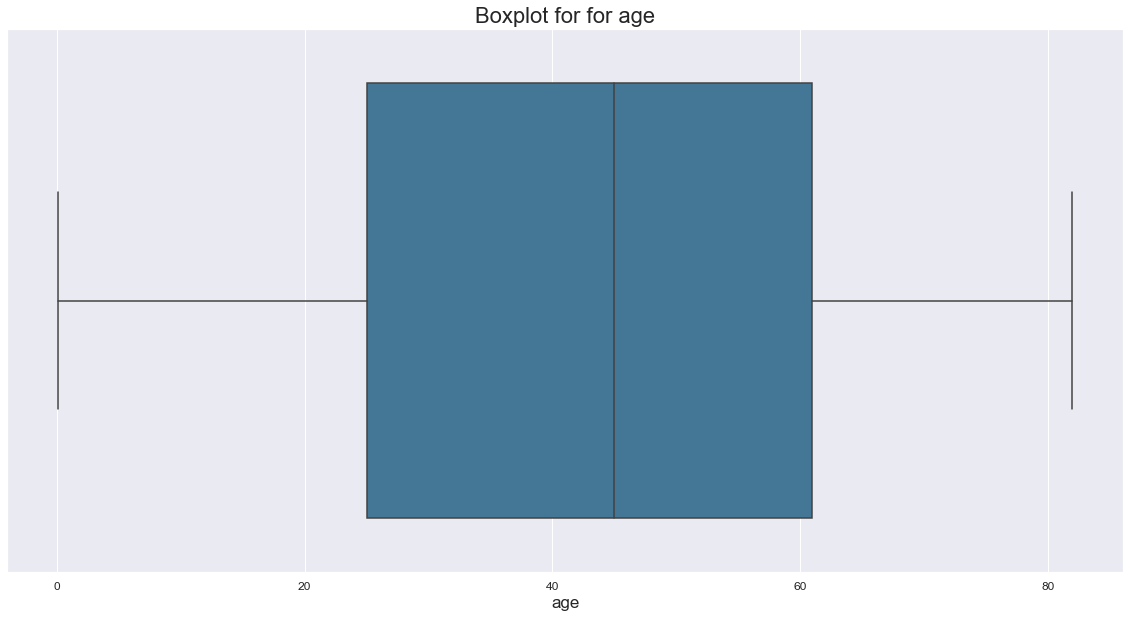

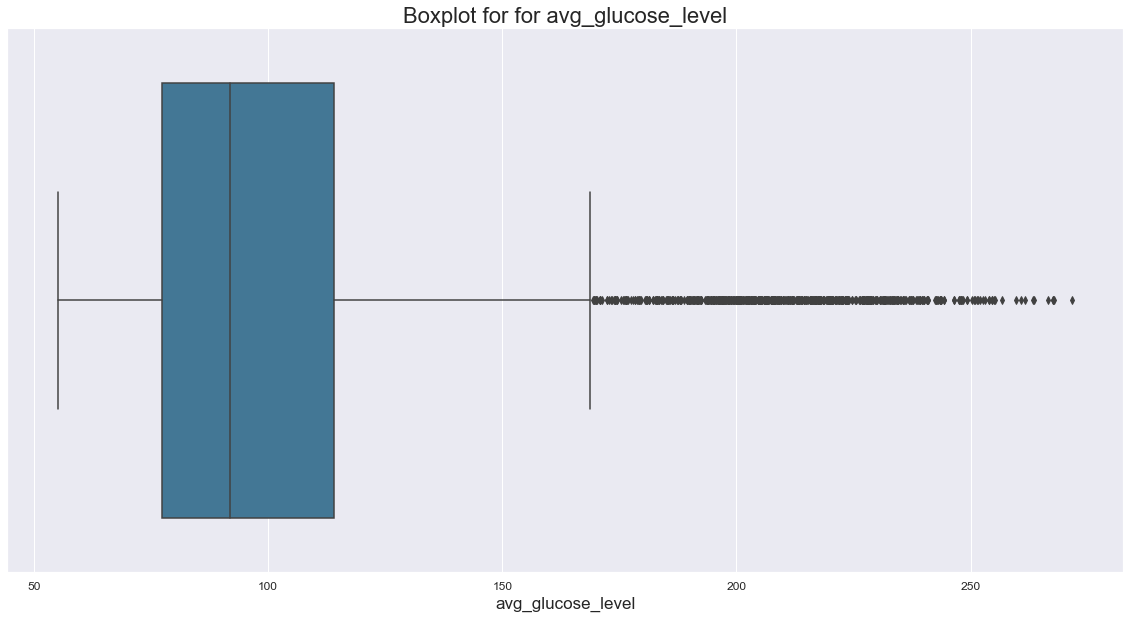

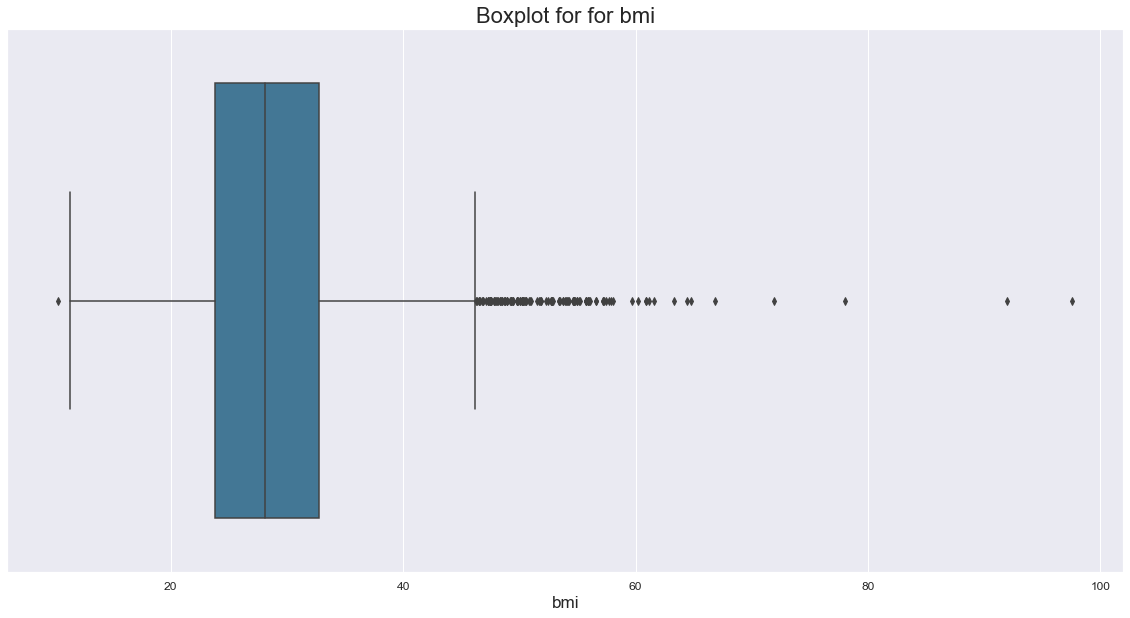

In [20]:
sns.set(rc={'figure.figsize':(20,10)})
width = 15
height = 8
feats = list(numeric_feats)
feats.remove('id')
for feature in feats:

    fig=sns.boxplot(
        x=df[feature], 
        hue=df['stroke'], 
        palette = 'mako',
    )
    plt.title(f'Boxplot for for {feature}', fontsize=22)
    plt.xlabel(f'{feature}' , fontsize=17)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(fig_dir+f'{feature}_box.png')
    plt.show()

### Outliers

In [21]:
def detect_outliers(df,feature):
    outlier_indices = []
    c=feature
    Q1 = np.percentile(df[c],25)
    Q3 = np.percentile(df[c],75)
    IQR = Q3 - Q1
    outlier_step = IQR * 1.5
    upper = outlier_step+Q3
    lower = Q1-outlier_step
    outlier_list_col = df[(df[c] < lower) | (df[c] > upper)].index

    return df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)] , upper , lower


In [22]:
# with imputation 
glucose_outliers , glucose_upper , glucose_lower = detect_outliers(df,'avg_glucose_level') 
age_outliers, age_upper , age_lower = detect_outliers(df,'age') 
bmi_outliers, bmi_upper,  bmi_lower = detect_outliers(df,'bmi')
print(f'#Outliers for avg_glucose_level: {len(glucose_outliers)}. Upper: {round(glucose_upper,2)}. Lower: {round(glucose_lower)}')
print(f'#Outliers for age: {len(age_outliers)}. Upper: {round(age_upper)}. Lower: {round(age_lower)}')
print(f'#Outliers for bmi: {len(bmi_outliers)}. Upper: {round(bmi_upper)}. Lower: {round(bmi_lower)}')

#Outliers for avg_glucose_level: 627. Upper: 169.36. Lower: 22
#Outliers for age: 0. Upper: 115. Lower: -29
#Outliers for bmi: 126. Upper: 46. Lower: 10


## Data Preparation

In [23]:
df = df.drop('id',axis=1)

### Outlier Clamping

In [24]:
def clamp_outliers(df,feature):
    df_rows , upper, lower  = detect_outliers(df,feature)
    df_new = df.copy()
    for row in df_rows.index:
        if df_rows.loc[row,feature] > upper:
            df_new.loc[row,feature] = upper
        elif df_rows.loc[row,feature] < lower:
            df_new.loc[row,feature] = lower            
    return df_new
df_clamp =clamp_outliers(df,'avg_glucose_level')
df_clamp =clamp_outliers(df_clamp,'age')
df_clamp =clamp_outliers(df_clamp,'bmi')

glucose_outliers , glucose_upper , glucose_lower = detect_outliers(df_clamp,'avg_glucose_level') 
age_outliers, age_upper , age_lower = detect_outliers(df_clamp,'age') 
bmi_outliers, bmi_upper,  bmi_lower = detect_outliers(df_clamp,'bmi')
print(f'#Outliers for avg_glucose_level: {len(glucose_outliers)}. Upper: {round(glucose_upper,2)}. Lower: {round(glucose_lower)}')
print(f'#Outliers for age: {len(age_outliers)}. Upper: {round(age_upper)}. Lower: {round(age_lower)}')
print(f'#Outliers for bmi: {len(bmi_outliers)}. Upper: {round(bmi_upper)}. Lower: {round(bmi_lower)}')
df=df_clamp

#Outliers for avg_glucose_level: 0. Upper: 169.36. Lower: 22
#Outliers for age: 0. Upper: 115. Lower: -29
#Outliers for bmi: 0. Upper: 46. Lower: 10


### Datatype conversion

In [25]:
df.age = df.age.astype(int)

### Irregular Cardinality

In [26]:
print(len(df[df['gender']=='Other']))
df = df.drop(df[df.gender=='Other'].index)

1


### Missing Values

In [27]:
print("Missing values per feature\n")
null_features = df.isnull().sum() 
print(null_features,'\n')
percent_missing_bmi = round((null_features['bmi']/df.shape[0]*100),2)
percent_missing_smoking = round((null_features['smoking_status']/df.shape[0]*100),2)

print(f'% values missing for bmi: {percent_missing_bmi}% ')
print(f'% values missing for smoking_status: {percent_missing_smoking}% ')
rows_with_missing = df.shape[0] - df.dropna().shape[0]
percent_rows_missing = round(rows_with_missing/df.shape[0],4)*100
print('Number of rows with at least one missing value: ', rows_with_missing)
print('Percentage of rows with at least one missing value:', percent_rows_missing,'%')

Missing values per feature

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64 

% values missing for bmi: 0.0% 
% values missing for smoking_status: 0.0% 
Number of rows with at least one missing value:  0
Percentage of rows with at least one missing value: 0.0 %


### Feature Types

In [28]:
feats = df.columns.values
numeric_feats = df._get_numeric_data().columns.values
cat_feats = list(set(feats) - set(numeric_feats))

print("Features:\n",feats,'\n\n')
print("Numerical Features:\n",numeric_feats,'\n\n')
print("Categorical Features:\n",cat_feats,'\n\n')
print('Feature Datatypes')
print(df.dtypes)

Features:
 ['gender' 'age' 'hypertension' 'heart_disease' 'ever_married' 'work_type'
 'Residence_type' 'avg_glucose_level' 'bmi' 'smoking_status' 'stroke'] 


Numerical Features:
 ['age' 'avg_glucose_level' 'bmi'] 


Categorical Features:
 ['smoking_status', 'Residence_type', 'stroke', 'gender', 'heart_disease', 'work_type', 'hypertension', 'ever_married'] 


Feature Datatypes
gender                object
age                    int32
hypertension          object
heart_disease         object
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                object
dtype: object


In [29]:
for feat in cat_feats:
    print(feat , ':',df[feat].unique())

smoking_status : ['formerly smoked' 'never smoked' 'smokes' 'Unknown']
Residence_type : ['Urban' 'Rural']
stroke : ['Yes' 'No']
gender : ['Male' 'Female']
heart_disease : ['Yes' 'No']
work_type : ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
hypertension : ['No' 'Yes']
ever_married : ['Yes' 'No']


### Data Quality Report

In [30]:
print('Data Quality Report for Numerical Features')
display(df.describe())
print('Data Quality Report for Categorical Features')
display(df.describe(include='object'))

Data Quality Report for Numerical Features


,age,avg_glucose_level,bmi
count,5109.000000,5109.000000,5109.000000
mean,43.218634,100.987918,28.691642
std,22.634799,33.212706,7.121011
min,0.000000,55.120000,10.300000
25%,25.000000,77.240000,23.800000
50%,45.000000,91.880000,28.100000
75%,61.000000,114.090000,32.800000
max,82.000000,169.357500,46.300000


Data Quality Report for Categorical Features


,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke
count,5109,5109,5109,5109,5109,5109,5109,5109
unique,2,2,2,2,5,2,4,2
top,Female,No,No,Yes,Private,Urban,never smoked,No
freq,2994,4611,4833,3353,2924,2596,1892,4860


### Encoding Schemes

#### CatBoost Encoder

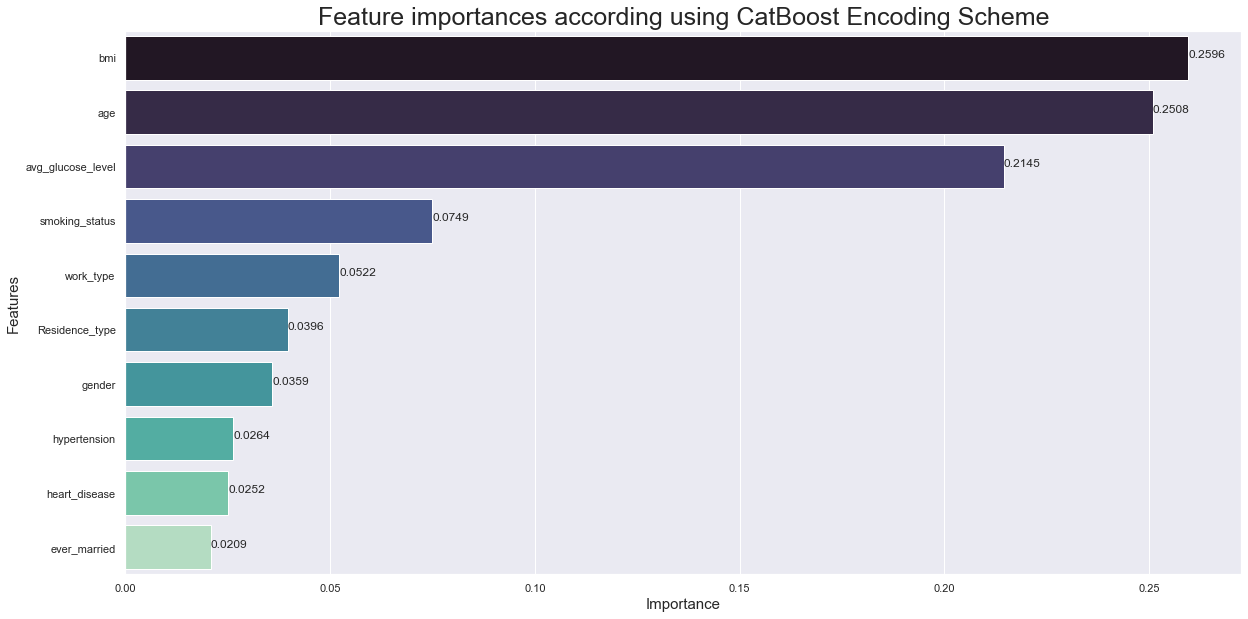

In [31]:
X= df[df.columns.difference(['stroke'])]
y= df.stroke
y_mapped =  y.map({'Yes':1 , 'No':0})
cbe_encoder = ce.cat_boost.CatBoostEncoder()

# Fit encoder and transform the features
cbe_encoder.fit(X, y_mapped)
df_cbe = cbe_encoder.transform(X)

rf = RandomForestClassifier(n_estimators=100)
rf.fit(df_cbe,y)
importances = list(rf.feature_importances_)
cbe_imp = importances
columns = list(X.columns.values)
# id_index =list(columns).index('id')
# columns.remove('id')
# importances.remove(importances[id_index])
n = len(importances)
for i in range(len(importances)-1):
    for j in range(0,n-i-1):
        if importances[j]<importances[j+1]:
            importances[j], importances[j+1] = importances[j+1], importances[j]
            columns[j], columns[j+1] = columns[j+1], columns[j]
            
plt.figure(figsize = (20,10))
fig = sns.barplot(y=columns,
            x=importances,
            palette='mako'
)

for index, value in enumerate(np.round(np.array(importances),4)):
    plt.text(value, index, str(value), fontsize=12)
plt.title('Feature importances according using CatBoost Encoding Scheme', fontsize=25)
plt.xlabel('Importance' , fontsize=15)
plt.ylabel('Features', fontsize=15)
plt.savefig(fig_dir+'feat_impo_cbe.png')
plt.show()


#### Target Encoder

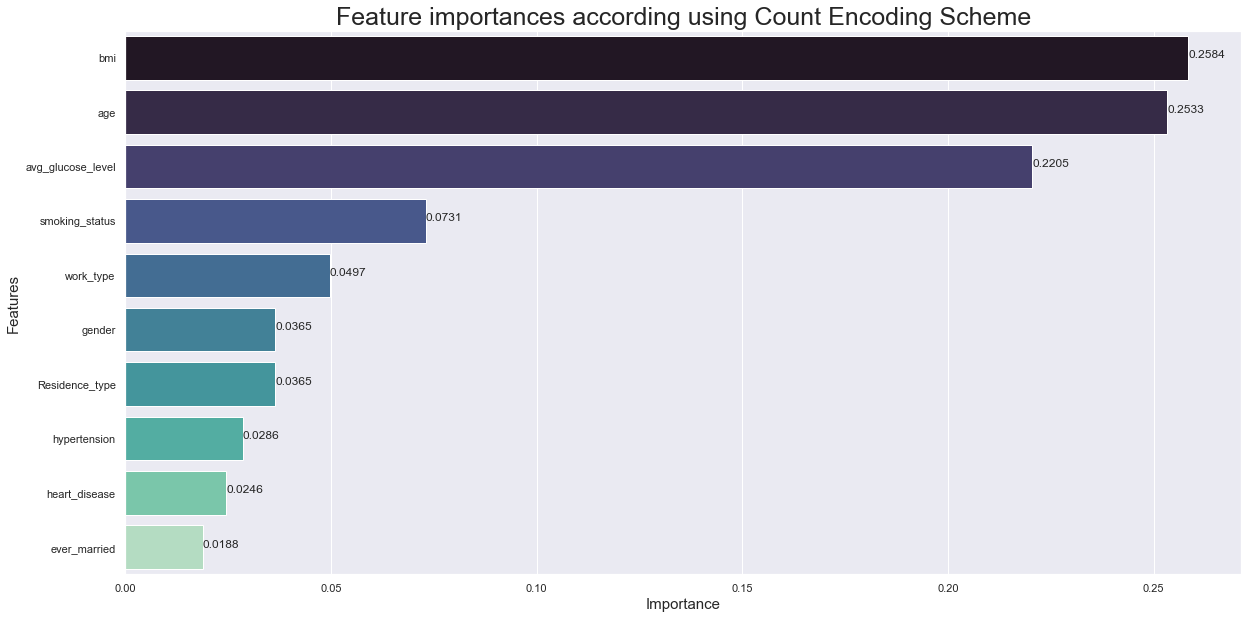

In [32]:
X= df[df.columns.difference(['stroke'])]
y= df.stroke
y_mapped =  y.map({'Yes':1 , 'No':0})
ce_encoder = ce.count.CountEncoder()

# Fit encoder and transform the features
ce_encoder.fit(X, y_mapped)
df_ce = ce_encoder.transform(X)

rf = RandomForestClassifier(n_estimators=100)
rf.fit(df_ce,y)
importances = list(rf.feature_importances_)
ce_imp = importances
columns = list(X.columns.values)
# id_index =list(columns).index('id')
# columns.remove('id')
# importances.remove(importances[id_index])
n = len(importances)
for i in range(len(importances)-1):
    for j in range(0,n-i-1):
        if importances[j]<importances[j+1]:
            importances[j], importances[j+1] = importances[j+1], importances[j]
            columns[j], columns[j+1] = columns[j+1], columns[j]
            
plt.figure(figsize = (20,10))
fig = sns.barplot(y=columns,
            x=importances,
            palette='mako'
)

for index, value in enumerate(np.round(np.array(importances),4)):
    plt.text(value, index, str(value), fontsize=12)
plt.title('Feature importances according using Count Encoding Scheme', fontsize=25)
plt.xlabel('Importance' , fontsize=15)
plt.ylabel('Features', fontsize=15)
plt.savefig(fig_dir+'feat_impo_ce.png')
plt.show()


### Feature Selection

#### Inter-feature correlation

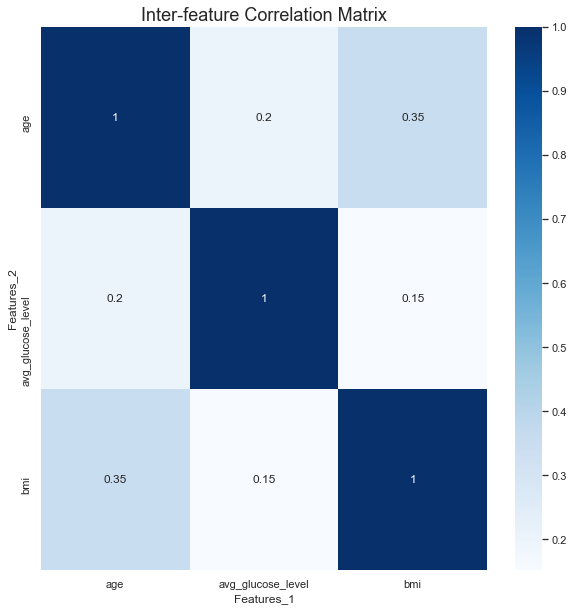

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(),annot=True,cmap='Blues')
plt.title('Inter-feature Correlation Matrix',fontsize=18)
plt.xlabel('Features_1' , fontsize = 12)
plt.ylabel('Features_2' , fontsize = 12)
plt.savefig(fig_dir+'feat_corr.png')

#### Feature Importance

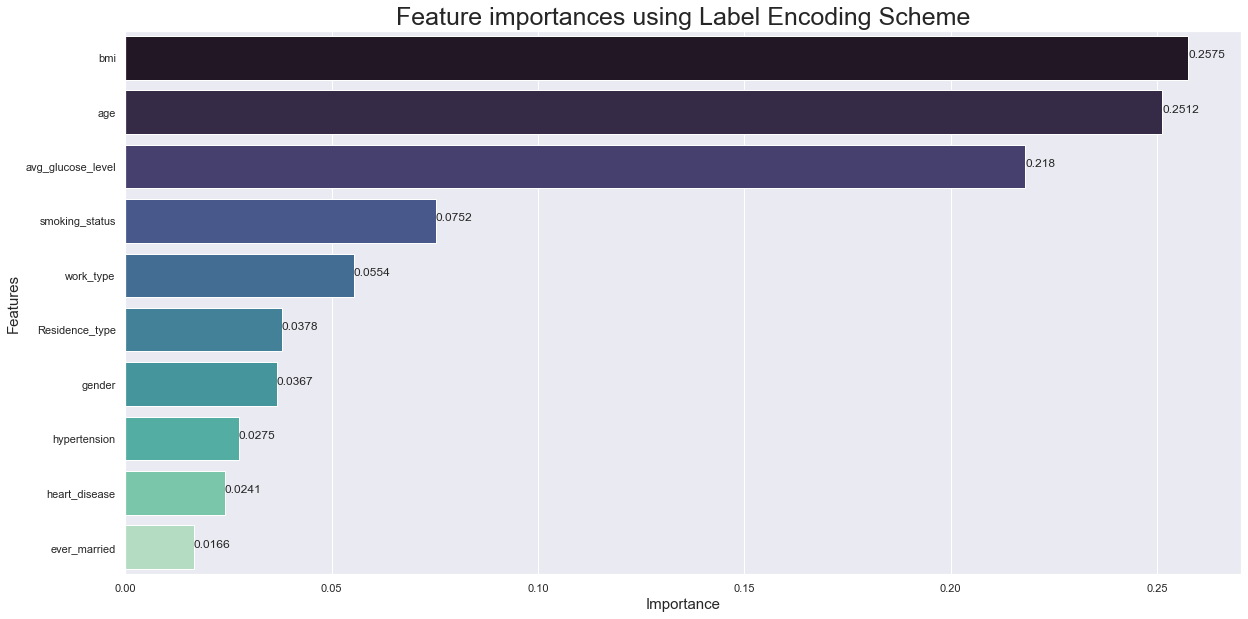

In [34]:
encoder = le()
for feat in cat_feats:
    df[feat] = encoder.fit_transform(df[feat].values)
    
X= df[df.columns.difference(['stroke'])]
y= df.stroke
encoder = le()

    
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X,y)
importances = list(rf.feature_importances_)
le_imp = importances
columns = list(X.columns.values)
# id_index =list(columns).index('id')
# columns.remove('id')
# importances.remove(importances[id_index])
n = len(importances)
for i in range(len(importances)-1):
    for j in range(0,n-i-1):
        if importances[j]<importances[j+1]:
            importances[j], importances[j+1] = importances[j+1], importances[j]
            columns[j], columns[j+1] = columns[j+1], columns[j]
            
plt.figure(figsize = (20,10))
fig = sns.barplot(y=columns,
            x=importances,
            palette='mako'
)

for index, value in enumerate(np.round(np.array(importances),4)):
    plt.text(value, index, str(value), fontsize=12)
plt.title('Feature importances using Label Encoding Scheme', fontsize=25)
plt.xlabel('Importance' , fontsize=15)
plt.ylabel('Features', fontsize=15)
plt.savefig(fig_dir+'feat_impo_le.png')
plt.show()


In [35]:
(np.array(le_imp) - np.array(ce_imp)).sum()

5.204170427930421e-17

In [36]:
(np.array(le_imp) - np.array(cbe_imp)).sum()

3.469446951953614e-17

In [37]:
df_ce['stroke']= y

In [38]:
df_ce.head()

,Residence_type,age,avg_glucose_level,bmi,ever_married,gender,heart_disease,hypertension,smoking_status,work_type,stroke
0,2596,67,169.3575,36.6,3353,2115,276,4611,884,2924,1
1,2513,61,169.3575,28.1,3353,2994,4833,4611,1892,819,1
2,2513,80,105.9200,32.5,3353,2115,276,4611,1892,2924,1
3,2596,49,169.3575,34.4,3353,2994,4833,4611,789,2924,1
4,2513,79,169.3575,24.0,3353,2994,4833,498,1892,819,1
